In [22]:
# استيراد المكتبات

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import skew



In [23]:

#  تحميل البيانات

!gdown --id 12-MyInzLU4mPbOSPaLtt6o0oj706Xmcx
df = pd.read_csv("train.csv")


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12-MyInzLU4mPbOSPaLtt6o0oj706Xmcx
To: /content/train.csv
100% 2.13M/2.13M [00:00<00:00, 124MB/s]


In [25]:
#تعديل اسماء الاعمدة
df.columns = df.columns.str.strip()

In [26]:
#إظهار اسماء الاعمدة
print(df.columns)

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')


In [27]:
# عرض أول 5 صفوف
df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [28]:
# عرض أبعاد البيانات (عدد الصفوف وعدد الأعمدة) لمعرفة حجم مجموعة البيانات
df.shape

(9800, 18)

In [29]:
# فحص القيم المفقودة في كل عمود للتأكد من أن البيانات نظيفة قبل تدريب النموذج
df.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [30]:
#حذف الاعمدة غير الضرورية
df = df.drop(columns=["Row ID", "Customer Name", "Order ID","Postal Code","Product Name","Customer ID"], errors="ignore")


In [31]:
# فحص القيم المفقودة في كل عمود للتأكد من أن البيانات نظيفة قبل تدريب النموذج
df.isnull().sum()

,0
Order Date,0
Ship Date,0
Ship Mode,0
Segment,0
Country,0
City,0
State,0
Region,0
Product ID,0
Category,0


In [32]:
#فصل عامود المبيعات لوحدة
X = df.drop("Sales", axis=1)
y = df["Sales"]


In [33]:
 # ملخص إحصائي آخر للبيانات الرقمية يساعد على فهم توزيعها والقيم الشاذة
df.describe()


,Sales
count,9800.000000
mean,230.769059
std,626.651875
min,0.444000
25%,17.248000
50%,54.490000
75%,210.605000
max,22638.480000


In [34]:
#التحقق من القيم الشاذة
Q1 = df["Sales"].quantile(0.25)
Q3 = df["Sales"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["Sales"] < lower_bound) | (df["Sales"] > upper_bound)]

print("Number of outliers:", len(outliers))


Number of outliers: 1145


<Axes: >

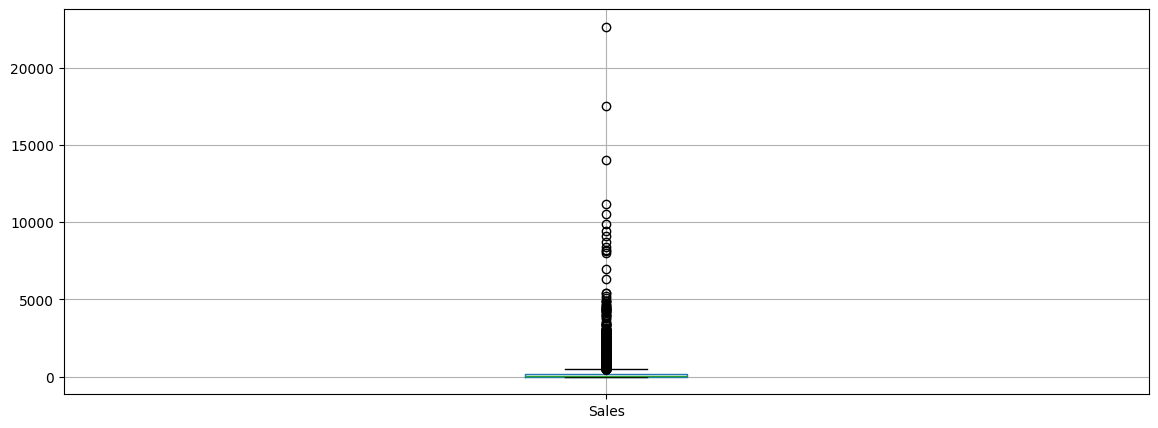

In [35]:
# يرسم مخطط صندوق لكل عمود رقمي لتصور توزيع البيانات واكتشاف القيم الشاذة
plt.figure(figsize=(14,5))
df.boxplot()

In [36]:
# دالة لتعديل القيم الشاذة باستخدام IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # استبدال القيم الأقل من الحد الأدنى بالحد الأدنى
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

    # استبدال القيم الأعلى من الحد الأعلى بالحد الأعلى
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df

# مثال على التطبيق
df = cap_outliers(df, "Sales")


<Axes: >

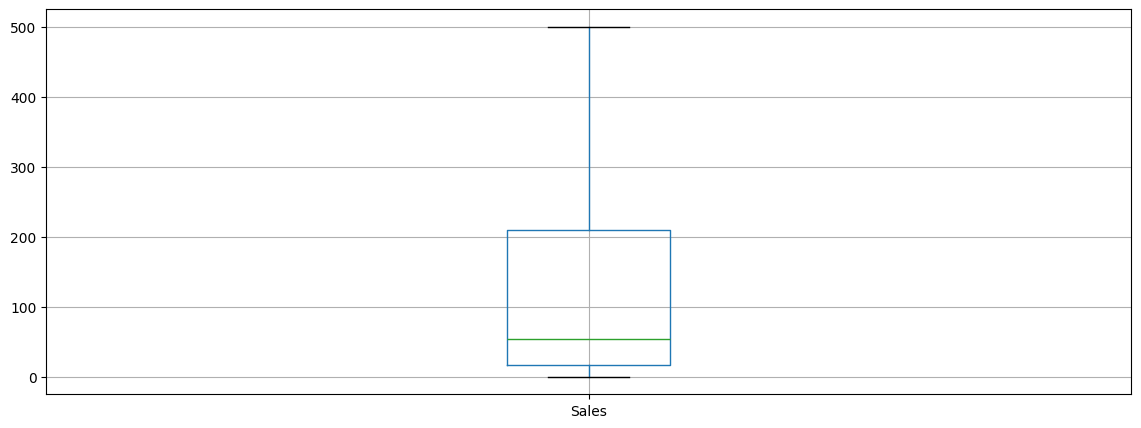

In [37]:
# يرسم مخطط صندوق لكل عمود رقمي لتصور توزيع البيانات واكتشاف القيم الشاذة
plt.figure(figsize=(14,5))
df.boxplot()

In [38]:
# تحويل البيانات التاريخ
df["Order Date"] = pd.to_datetime(df["Order Date"], dayfirst=True)

# استخراج السنة
df["Year"] = df["Order Date"].dt.year

# استخراج الشهر
df["Month"] = df["Order Date"].dt.month

# استخراج اليوم
df["Day"] = df["Order Date"].dt.day

In [39]:
# بعد الاستخراج نحذف العمود الأصلي
df = df.drop(["Order Date"], axis=1)

In [43]:
#encoding للاعمدة النصية
df_encoded = pd.get_dummies(df, drop_first=True)

In [47]:
# تحويل كل الأعمدة النصية إلى أعمدة رقمية
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# إذا بعض الأعمدة في X_test غير موجودة في X_train، تأكد من توحيد الأعمدة
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [48]:
#للتأكيد
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6860, 4817) (1470, 4817)
(6860,) (1470,)


In [49]:
# احصائيات Sales قبل التحويل
max_price = df["Sales"].max()
min_price = df["Sales"].min()
mean_price = df["Sales"].mean()
median_price = df["Sales"].median()
std_price = df["Sales"].std()

print("اعلى سعر:", max_price)
print("ادنى سعر:", min_price)
print("المتوسط:", mean_price)
print("الوسيط:", median_price)
print("الانحراف المعياري:", std_price)

# حساب الالتواء
skewness = skew(df["Sales"])
print("قيمة الانحراف:", skewness)

اعلى سعر: 500.6405000000001
ادنى سعر: 0.444
المتوسط: 140.81579003061225
الوسيط: 54.489999999999995
الانحراف المعياري: 169.55161174738487
قيمة الانحراف: 1.217568819650099


In [50]:
# تحويل لوغاريتمي لتقليل الانحراف
df["Sales_log"] = np.log1p(df["Sales"])

new_skewness = skew(df["Sales_log"])
print("قيمة الانحراف بعد التحويل:", new_skewness)

print("المتوسط بعد التحويل:", df["Sales_log"].mean())
print("الوسيط بعد التحويل:", df["Sales_log"].median())
print("الانحراف المعياري بعد التحويل:", df["Sales_log"].std())

قيمة الانحراف بعد التحويل: -0.047087927277242835
المتوسط بعد التحويل: 4.076405588952566
الوسيط بعد التحويل: 4.01620280809951
الانحراف المعياري بعد التحويل: 1.448123703200245


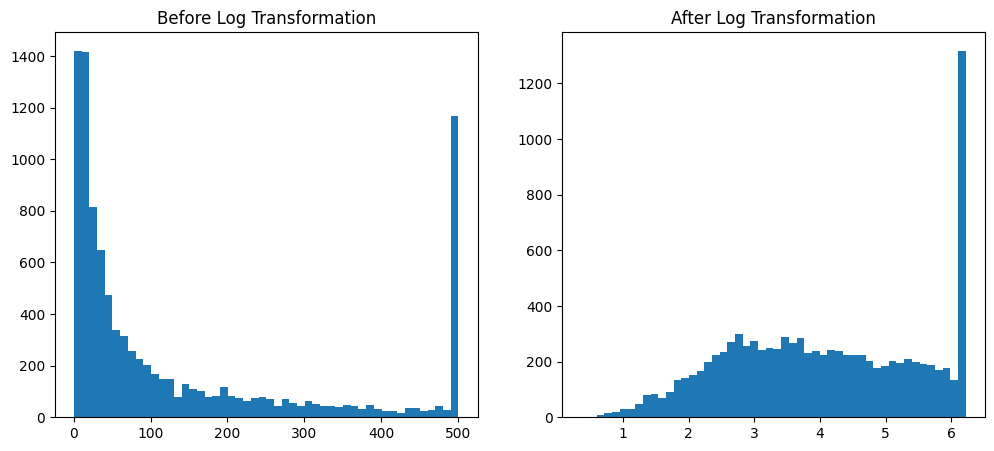

In [51]:
#رسم بياني قبل وبعد التحويل
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df["Sales"], bins=50)
plt.title("Before Log Transformation")

plt.subplot(1,2,2)
plt.hist(df["Sales_log"], bins=50)
plt.title("After Log Transformation")

plt.show()

In [46]:
#تقسيم البيانات ل
# 70 % تدريب
# 12% تحقق
# 15% اختبار

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)



In [52]:
#scaling
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

In [ ]:
#الان فما تحت التدريب#

In [53]:
#تدريب
lr_pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [54]:
# التقييم باستخدام بيانات التحقق
# توحيد أعمدة X_val مثل X_train
X_val = pd.get_dummies(X_val)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

# التنبؤ على بيانات التحقق
y_val_pred = lr_pipe.predict(X_val)

# حساب مقاييس التقييم
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)

# طباعة النتائج
print("Validation MSE:", mse_val)
print("Validation RMSE:", rmse_val)
print("Validation R2 Score:", r2_val)


Validation MSE: 439737.67648489104
Validation RMSE: 663.1271948011868
Validation R2 Score: -0.09612653618824152


In [55]:
#التقييم باستخام بيانات الاختبار
# التأكد من توحيد أعمدة X_test مثل X_train
X_test = pd.get_dummies(X_test)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# التنبؤ على بيانات الاختبار
y_test_pred = lr_pipe.predict(X_test)

# حساب مقاييس التقييم
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# طباعة النتائج
print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)
print("Test R2 Score:", r2_test)


Test MSE: 651237.2662228234
Test RMSE: 806.9927299690025
Test R2 Score: 0.20348329949668698


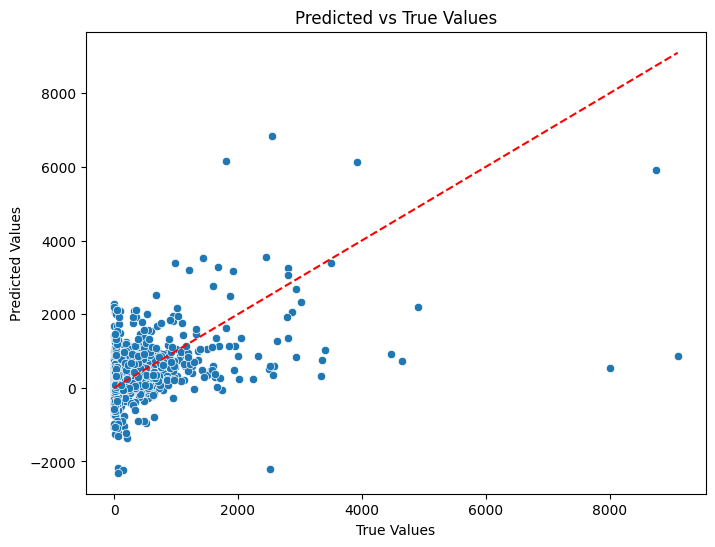

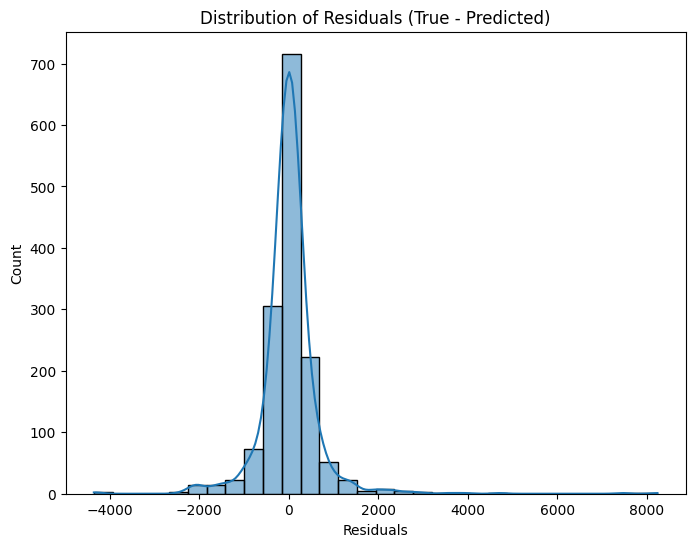

In [56]:
# التنبؤ بالقيم
y_pred = lr_pipe.predict(X_val)  # أو X_test

# Scatter plot: True vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.show()

# Residuals distribution
residuals = y_val - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals (True - Predicted)")
plt.show()


In [57]:
X_train = X_train.drop(columns=["Sales_log"], errors="ignore")
X_val = X_val.drop(columns=["Sales_log"], errors="ignore")
X_test = X_test.drop(columns=["Sales_log"], errors="ignore")